<a href="https://colab.research.google.com/github/akshatgoel92/intro-dl-3/blob/master/src/Copy_of_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import packages
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import packages
%reset -f
import pprint
import os
import gzip
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def load_mnist(path, kind='train'):
    '''
    Load MNIST data from specified path
    '''
    
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
def _filter(xs, ys, lbls):
    '''
    Filter observations to construct relevant dataset
    '''
    idxs = [i for (i, l) in enumerate(ys) if l in lbls]
    return xs[idxs, :], ys[idxs]

In [5]:
def clear_gpu(model):
   '''
   Removes model from GPU and clears memory
   '''
   model = model.to('cpu')
   del model
   torch.cuda.empty_cache()

In [6]:
class Dataset(torch.utils.data.Dataset):
    '''
    Basic dataset class to work with Torch data loader
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        # No. of rows in feature array should equal no. of examples
        assert len(X) == len(y), print("Number of examples don't match up")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [7]:
class Net(torch.nn.Module):
  '''
  Basic convolutional neural network class
  '''
  def __init__(self):
    '''
    Architecture definition
    '''
    super(Net, self).__init__()
    # 1 input image channel, 6 output channels (outputting 6 convolutional features), 3x3 square convolution
    self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
    self.pool = torch.nn.MaxPool2d(2, 2)
    # 6 input image channel, 16 output channels (outputting 16 convolutional features), 5x5 square convolution
    self.conv2 = torch.nn.Conv2d(6, 16, 5)
    self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
    self.fc2 = torch.nn.Linear(120, 84)
    self.fc3 = torch.nn.Linear(84, 5)
    
  def forward(self, x):
    '''
    Forward propagation
    '''
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) 
    
    return x

In [8]:
  def get_data(dataloader_params, path='/content/drive/MyDrive/data'): 
    '''
    Prepare data
    '''
    # Load data
    train_images, train_labels = load_mnist(path, 'train')
    test_images, test_labels = load_mnist(path, 't10k')
    
    # Validation images
    val_images = train_images[50000:]
    val_labels = train_labels[50000:]
    
    # Train images
    train_images = train_images[:50000]
    train_labels = train_labels[:50000]
    
    # Filter the relevant images according to the problem specification
    X_train, Y_train = _filter(train_images, train_labels, [0, 1, 4, 5, 8])
    X_val, Y_val = _filter(val_images, val_labels, [0, 1, 4, 5, 8])
    X_test, Y_test = _filter(test_images, test_labels, [0, 1, 4, 5, 8])

    for Y in [Y_train, Y_val, Y_test]:
      Y[Y == 4] =  2
      Y[Y == 5] =  3
      Y[Y == 8] =  4
    
    # Reshape data into 28 X 28 format
    X_train = X_train.reshape(X_train.shape[0], 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 28, 28)
    X_val = X_val.reshape(X_val.shape[0], 28, 28)
    
    # Add new axis to to make sure 
    X_train = X_train[:, np.newaxis, :, :]
    X_test = X_test[:, np.newaxis, :, :]
    X_val = X_val[:, np.newaxis, :, :]
    
    # Dataset
    train_data = Dataset(X_train, Y_train)
    train_generator = torch.utils.data.DataLoader(train_data, **dataloader_params)
    
    # Convert into torch tensors and send to device
    X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
    Y_train = torch.Tensor(Y_train).type(torch.LongTensor)
    
    # Convert into torch tensors and send to device
    X_val = torch.from_numpy(X_val).type(torch.FloatTensor)
    Y_val = torch.Tensor(Y_val).type(torch.LongTensor)
    
    # Convert into torch tensors and send to device
    X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
    Y_test = torch.Tensor(Y_test).type(torch.LongTensor)
    
    # Return statement
    return(train_generator, X_train, Y_train, X_val, Y_val, X_test, Y_test)

In [9]:
def train(meta, question_no, model_num, epochs=30, batch_size=32, lr=0.1, weight_decay=0, test=False, feature_maps=False):
    '''
    Main training loop for convolutional network
    '''
    # Set the seed so each experiment is reproducible
    np.random.seed(21390)
    torch.manual_seed(10394)

    # Set parameters
    dataloader_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 6}
    epochs = epochs
  
    # Store results here
    history = {
        'train_accuracy': [],
        'train_loss': [], 
        'val_accuracy': [],
        'val_loss': []
    }
  
    # Load data
    train_generator, X_train, Y_train, X_val, Y_val, X_test, Y_test = get_data(dataloader_params)
  
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send all these objects to the relevant device
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    # Validation set to GPU
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    # Testing set to GPU
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)

    # Create the neural network objects and parameters
    net = Net().to(device)
  
    # Loss function
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Optimizer
  
    if meta["optimiser"] == "adam":
      #.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
      optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=weight_decay)
    elif meta["optimiser"] == "sgd":
      #.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False) torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
      optimizer = torch.optim.SGD(net.parameters(), lr=meta["lr"], momentum=meta["momentum"], weight_decay=meta["wd"])
    elif meta["optimiser"] == "rmsprop":
      #RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
      optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=weight_decay)
    elif meta["optimiser"] == "adagrad":
      #Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
      optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=weight_decay)
    # lr, weight_decay, 

    if not test:
      
        # Train for maximum number of epochs given here
        for epoch in tqdm(range(epochs)):
      
            # Initialize running loss value for this epoch
            running_loss = 0.0
      
            # Loop through the generator containing training images
            for i, data in enumerate(train_generator):

              # Retrieve inputs and labels
              inputs, labels = data

              # Send them to GPU 
              inputs = inputs.type(torch.FloatTensor).to(device)
              labels =  labels.type(torch.LongTensor).to(device)

              # Zero the optimizer gradients
              optimizer.zero_grad()

              # Forward propagation
              outputs = net.forward(inputs)

              # Compute loss
              loss = loss_fn(outputs, labels)
          
              # Backward propogation
              loss.backward()

              # Weight update
              optimizer.step()
      
            # Compute training loss
            with torch.no_grad():
          
              # Forward propagation
              out = net.forward(X_train)

              # Prediction 
              preds = out.argmax(axis=1)

              # Get accuracy 
              accuracy = sum(preds == Y_train)/len(Y_train)
          
              # Get loss 
              loss = loss_fn(out, Y_train)

              print("Train accuracy {}, Train Loss: {}".format(accuracy, loss))

              # Append to history record
              history['train_accuracy'].append(accuracy)
              history['train_loss'].append(loss)

          
            # Compute validation loss
            with torch.no_grad():
        
              # Forward propogation
              out = net.forward(X_val)

              # Prediction 
              preds = out.argmax(axis=1)
        
              # Calculate accuracy
              accuracy = sum(preds == Y_val)/len(Y_val)

              # Calculate loss 
              loss = loss_fn(out, Y_val)

              # Print statement
              print("Val. accuracy {}, Val. Loss:, {}".format(accuracy, loss))
        
              # Append to history record
              history['val_accuracy'].append(accuracy)
              history['val_loss'].append(loss)

            if epoch %5 == 0:
          
              model_state = {
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'history': history
                    }
          
              save_checkpoint(model_state, question_no, model_num)
    

        # Plot and save epoch by epoch results
        plot_results(history, 'loss', model_num=model_num)
        plot_results(history, 'accuracy', model_num=model_num)

        # Return statement
        if feature_maps:
          return(history, net, X_train)
        else:
          return(history)
        
    # If the test flag is True we execute this
    if test:

        # First use helper function given below to load checkpoints file
        checkpoint = load_checkpoint(question_no = question_no, model_num=model_num)

        # Load model state dictionary
        net.load_state_dict(checkpoint['model_state_dict'])
        
        # Load optimizer state dictionary
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Set model to evaluation mode to make sure any batch norm and dropout layers are set correctly
        net.eval()

        # Now do the testing process
        with torch.no_grad():
        
            # Forward propogation
            out = net.forward(X_test)
        
            # Prediction 
            preds = out.argmax(axis=1)
        
            # Calculate accuracy
            accuracy = sum(preds == Y_test)/len(Y_test)
        
            # Calculate loss 
            loss = loss_fn(out, Y_test)

            # Print success message
            print("Testing completed! Saving results now...")

            # Print accuracy 
            print(accuracy)

            # Print losss
            print(loss)
        
            # Append to history record
            checkpoint['test_accuracy'] = accuracy
        
            # Append loss to history record
            checkpoint['test_loss'] = loss

        # Return statement    
        return(preds, Y_test)

In [10]:
def plot_results(history, lab, model_num, path='/content/drive/MyDrive/'):
    '''
    Convenience function to plot results
    '''
    # Construct model name
    model_name = str(model_num) + '_' + lab + '.png'
    path = os.path.join(path, '1_figs', model_name)
    
    # Plot the results
    plt.plot(history['train_' + lab], label='Train')
    plt.plot(history['val_' + lab], label='Validation')
  
    # Add annotations
    plt.legend()
    plt.title(lab.title() + ' by Epoch')
  
    # Save the figure and close the plot
    plt.savefig(path)
    plt.show()
    plt.clf()

In [11]:
def get_results(question_no, model_num):
  '''
  Take in a results dictionary 
  and return epoch on which 
  minimum validation loss was
  reached, minimum val. loss on
  that epoch, and min. accuracy
  on that epoch
  '''
  # Load the trained weights
  checkpoint = load_checkpoint(question_no = question_no, model_num=model_num)

  # Load the history object which contains a record of losses
  history = checkpoint['history'] 

  # Find the epoch on which the minimum validation loss was reached
  best_val_epoch = np.argmin(np.array(history['val_loss']))
  
  # Store validation metrics
  best_epoch_val_loss = np.array(history['val_loss'][best_val_epoch])
  best_epoch_val_accuracy = np.array(history['val_accuracy'][best_val_epoch])

  # Store training metrics
  best_epoch_train_loss = np.array(history['train_loss'][best_val_epoch])
  best_epoch_train_accuracy = np.array(history['train_accuracy'][best_val_epoch])
  
  # Store best results in a list
  results = {'best_val_epoch': best_val_epoch, 
             'best_epoch_val_loss': best_epoch_val_loss, 
             'best_epoch_val_accuracy': best_epoch_val_accuracy, 
             'best_epoch_train_loss': best_epoch_train_loss,
             'best_epoch_train_accuracy': best_epoch_train_accuracy, 
             'final_train_loss': history['train_loss'][-1],
             'final_train_accuracy': history['train_accuracy'][-1],
             'final_val_loss': history['val_loss'][-1], 
             'final_val_accuracy': history['val_accuracy'][-1]}

  # Return statement
  return(results)

In [12]:
def save_checkpoint(model_state, question_no, model_num):
    '''
    Save model state using this function
    '''
    checkpoints_path = '/content/drive/MyDrive/1_checkpoints/{}_{}.pt'.format(question_no, model_num)
    
    torch.save(model_state, checkpoints_path)

In [13]:
def load_checkpoint(question_no, model_num):
    '''
    Save model state using this function
    '''
    # Create checkpoints path
    checkpoints_path = '/content/drive/MyDrive/1_checkpoints/{}_{}.pt'.format(question_no, model_num)

    # Load checkpoint
    checkpoint = torch.load(checkpoints_path)
    
    # Return statement
    return(checkpoint)

In [14]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def get_confusion_matrix(pred_list, lbl_list, question_no, model_num, dest_path='/content/drive/MyDrive/1_results'):
    '''
    Evaluate model on the test set
    '''
    cols = ['T-shirt/top', 'Trouser', 'Coat', 'Sandal', 'Bag']
    rows = ['T-shirt/top', 'Trouser', 'Coat', 'Sandal', 'Bag']

    conf_mat=confusion_matrix(lbl_list.numpy(), pred_list.numpy())
    cf = pd.DataFrame(conf_mat)
    cf.columns = cols 
    cf.index = rows

    cf.to_csv(os.path.join(dest_path, 'confusion_matrix_{}_{}.csv'.format(question_no, model_num)))
    print(cf)
      
    # Print per class accuracy
    class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
    ca = pd.DataFrame(class_accuracy).T

    ca.columns = cols
    ca.index = ['Accuracy']
    
    ca.to_csv(os.path.join(dest_path, 'class_accuracies_{}_{}.csv'.format(question_no, model_num)))
    print(ca)

In [15]:
def execute_train_pipeline(question_no, model_num, test, feature_maps):
    '''
    Execute training for different model objects
    '''
    if model_num == 10:
      # lr = 0.00001
      lr = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
      momentum = [0.0, 0.5, 0.9, 0.99]
      wd = [1E-1, 1E-2, 1E-3, 1E-4]
      for i in lr:
        for j in momentum:
          for z in wd:
            meta = {"optimiser": "sgd", "lr": i, "momentum": j, "wd": z}
            # if meta["optimiser"] == "adam":
            #   #.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
            #   optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=weight_decay)
            # elif meta["optimiser"] == "sgd":
            #   #.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False) torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
            #   optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.1)
            # elif meta["optimiser"] == "rmsprop":
            #   #RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
            #   optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=weight_decay)
            # elif meta["optimiser"] == "adagrad":
            #   #Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
            #   optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=weight_decay)
            print("     lr:", i, "momentum:", j, "wd:", z)
            results = train(meta, question_no, model_num, lr=0.001, batch_size=32, epochs=70, weight_decay=0.01, test=test, feature_maps=feature_maps)

    if test:
      
      # First make the confusion matrix
      get_confusion_matrix(*results, question_no, model_num)
      
      # Next store the
      final_results = get_results(question_no, model_num)

      pp = pprint.PrettyPrinter(indent=4)
      pp.pprint(final_results)

    if feature_maps:
      visulalise_feature_maps(*results)

In [16]:
def visulalise_feature_maps(net, x_train):
  conv_layers = [net.conv1, net.conv2] # we will save the 49 conv layers in this list

  

  # pass the image through all the layers
  results = [conv_layers[0](img)]
  for i in range(1, len(conv_layers)):
      # pass the result from the last layer to the next layer
      results.append(conv_layers[i](results[-1]))
  # make a copy of the `results`
  outputs = results

  # visualize 64 features from each layer 
  # (although there are more feature maps in the upper layers)
  for num_layer in range(len(outputs)):
      plt.figure(figsize=(30, 30))
      layer_viz = outputs[num_layer][0, :, :, :]
      layer_viz = layer_viz.data
      print(layer_viz.size())
      for i, filter in enumerate(layer_viz):
          if i == 64: # we will visualize only 8x8 blocks from each layer
              break
          plt.subplot(8, 8, i + 1)
          plt.imshow(filter, cmap='gray')
          plt.axis("off")
      print(f"Saving layer {num_layer} feature maps...")
      plt.savefig(f"../outputs/layer_{num_layer}.png")
      # plt.show()
      plt.close()

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
print(net)
net1 = Net().to(device)
print(net1)

if net.conv1==net1.conv2:
  print("true")
else: 
  print("false")

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)
Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)
false


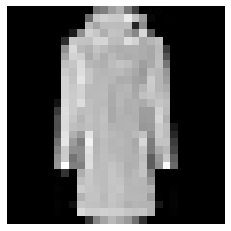

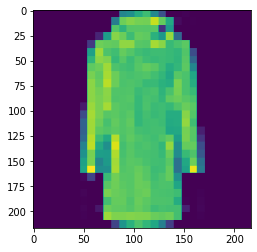

torch.Size([1, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([6, 512, 512])
Saving layer 0 feature maps...


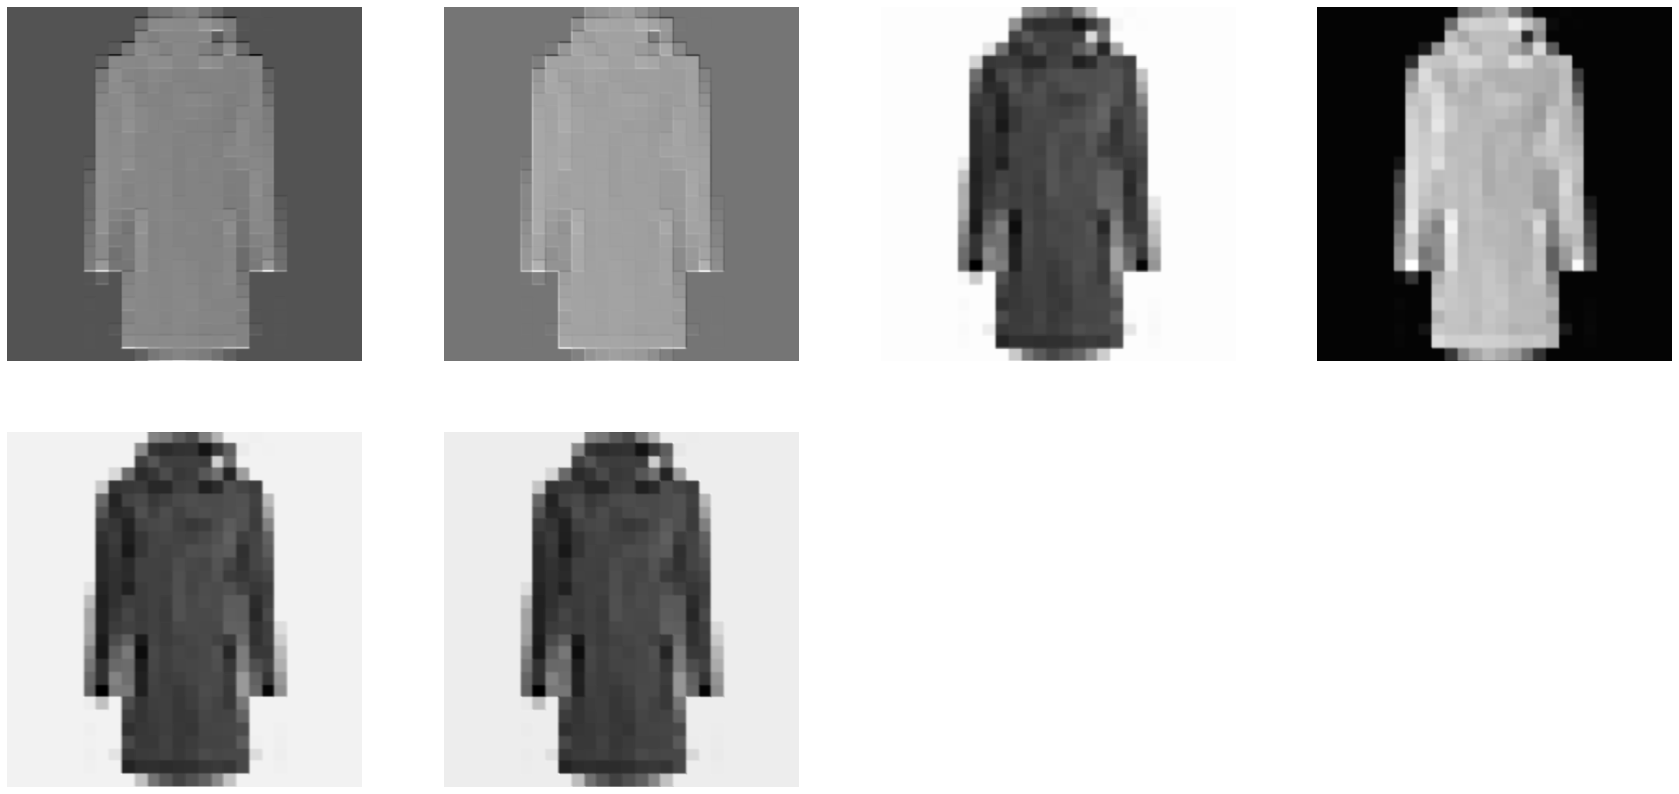

torch.Size([16, 508, 508])
Saving layer 1 feature maps...


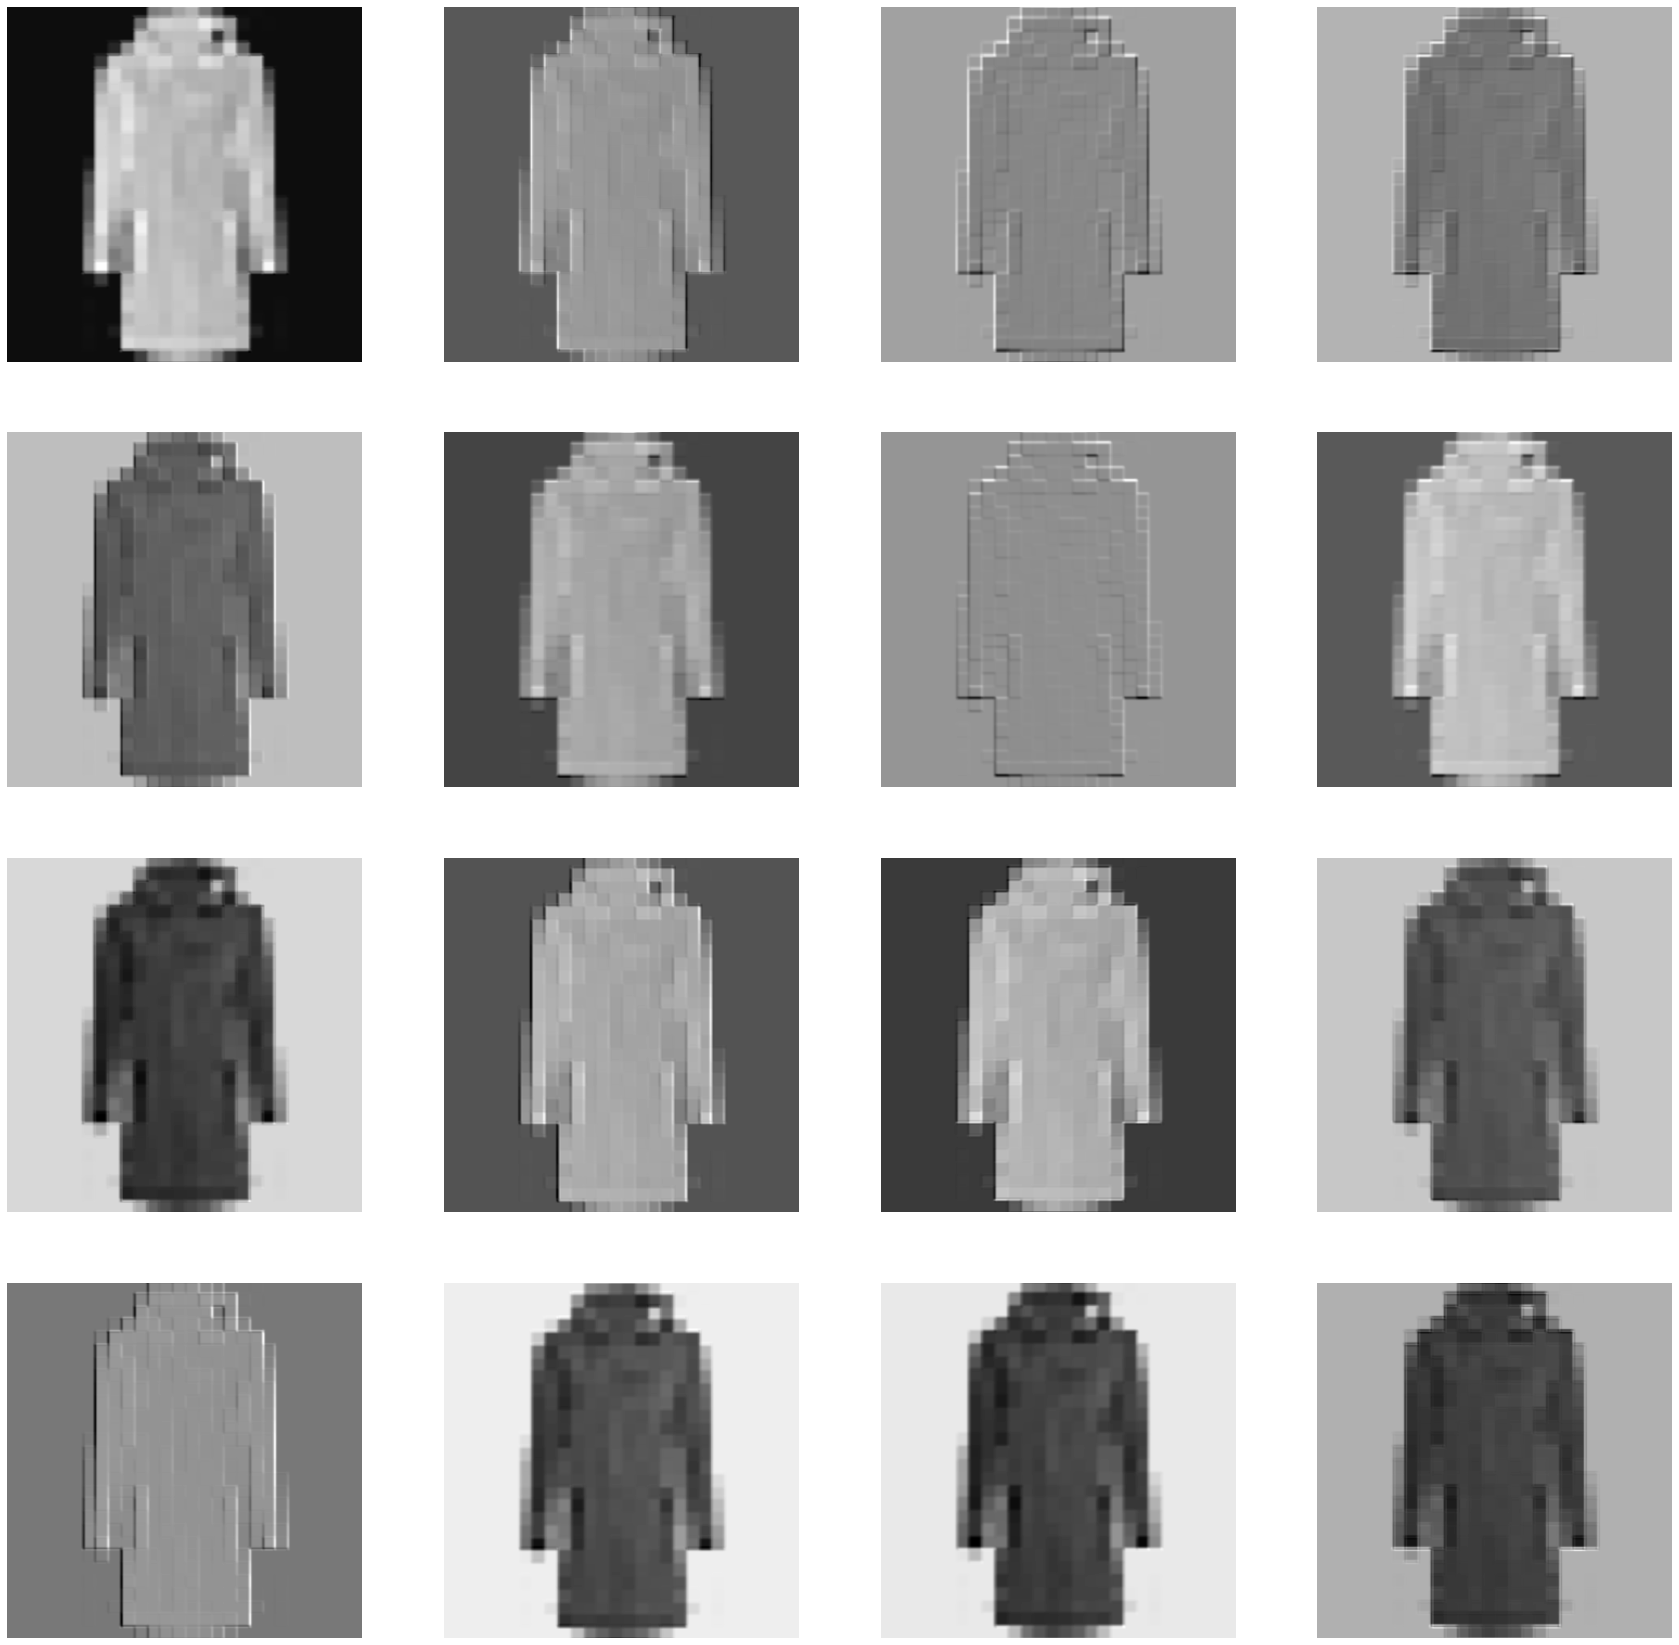

In [46]:
from torchvision import models, transforms
import torch.nn as nn
import cv2 as cv

model = models.resnet50(pretrained=True)
# print(model)
model_children = list(model.children())
# print("===========================")
# print(model_children)

# print(net.parameters())
meta = {"optimiser": "sgd"}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)


conv_layers = [net.conv1, net.conv2] # we will save the 49 conv layers in this list

classes = ('T-Shirt','Trouser','Pullover','Dress','Coat','Sandal', 'Shirt','Sneaker','Bag','Ankle Boot')
dataloader_params = {'batch_size': 32, 'shuffle': True, 'num_workers': 6}

train_generator, X_train, Y_train, X_val, Y_val, X_test, Y_test = get_data(dataloader_params, path='/content/drive/MyDrive/data')
# np.load(imgs_path)
# print(X_train[0])

train_images, train_labels = load_mnist('/content/drive/MyDrive/data', 'train')
# print(train_images[0])

print()

for batch_1 in train_generator:
    batch = batch_1
    break


# print(batch[0].shape) # as batch[0] contains the image pixels -> tensors
# print(batch[1].shape) # batch[1] contains the labels -> tensors

plt.figure()

for i in range (batch[0].shape[0]):
# i=0
  # plt.subplot(2, 4, i+1)  
  plt.axis('off')
  plt.imshow(batch[0][i].reshape(28, 28), cmap='gray')
  
  # plt.title(classes[batch[1][i]])
  plt.savefig('fashion_mnist.png', bbox_inches="tight", pad_inches=0)
  break
plt.show()

# read and visualize an image
# fashion = cv.imread(f"fashion_mnist.png")
# import matplotlib.image as mpimg

# im = cv.imread('fashion_mnist.png')
# im_resized = cv.resize(im, (28, 28), interpolation=cv.INTER_LINEAR)

# plt.imshow(fashion)
# plt.show()

# img = mpimg.imread('fashion_mnist.png')


# train(meta, 1, 10, lr=0.001, batch_size=32, epochs=70, weight_decay=0.01, test=False)

# read and visualize an image
# img = cv.imread(f"greyscale.png")
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# img = cv.imread('greyscale.png', cv.IMREAD_GRAYSCALE)
# print(img.shape)

# from PIL import Image
# img = Image.open('cat.jpg').convert('LA')
# img.save('greyscale.png')
   
# Window name in which image is displayed 
window_name = 'Image'

# Displaying the image  
# cv.imshow(window_name, img) 

# plt.imshow(fashion)
# plt.show()

img = cv.imread(f"fashion_mnist.png", cv.IMREAD_GRAYSCALE)

plt.imshow(img)
plt.show()
  
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())




# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        # if i == 64: # we will visualize only 8x8 blocks from each layer
        #     break
        plt.subplot(4, 4, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"./outputs/layer_{num_layer}.png")
    plt.show()
    plt.close()